In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("../data/Online Retail.xlsx")
df.shape

(541909, 8)

In [3]:
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df_clean = df.copy()


Keep only rows with valid CustomerID

In [7]:
df_clean = df_clean[df_clean["CustomerID"].notna()]
df_clean.shape

(406829, 8)

Remove cancelled invoices

In [8]:
df_clean = df_clean[~df_clean["InvoiceNo"].astype(str).str.startswith("C")]
df_clean.shape

(397924, 8)

In [9]:
df_clean = df_clean[
    (df_clean["Quantity"] > 0) &
    (df_clean["UnitPrice"] > 0)
]
df_clean.shape

(397884, 8)

Customer-Level Aggregation

In [11]:


reference_date = df_clean["InvoiceDate"].max()

customer_df = (
    df_clean
    .groupby("CustomerID")
    .agg(
        last_purchase_date=("InvoiceDate", "max"),
        num_orders=("InvoiceNo", "nunique"),
        total_quantity=("Quantity", "sum"),
        total_spent=("UnitPrice", "sum")
    )
    .reset_index()
)

customer_df["recency_days"] = (
    reference_date - customer_df["last_purchase_date"]
).dt.days

customer_df.head(), customer_df.shape


(   CustomerID  last_purchase_date  num_orders  total_quantity  total_spent  \
 0     12346.0 2011-01-18 10:01:00           1           74215         1.04   
 1     12347.0 2011-12-07 15:52:00           7            2458       481.21   
 2     12348.0 2011-09-25 13:13:00           4            2341       178.71   
 3     12349.0 2011-11-21 09:51:00           1             631       605.10   
 4     12350.0 2011-02-02 16:01:00           1             197        65.30   
 
    recency_days  
 0           325  
 1             1  
 2            74  
 3            18  
 4           309  ,
 (4338, 6))

### Create churn label using 90-day inactivity rule

In [12]:


customer_df["churn"] = (customer_df["recency_days"] > 90).astype(int)

customer_df[["CustomerID", "recency_days", "churn"]].head()


,CustomerID,recency_days,churn
0,12346.0,325,1
1,12347.0,1,0
2,12348.0,74,0
3,12349.0,18,0
4,12350.0,309,1


### Inspect churn distribution

In [13]:


churn_counts = customer_df["churn"].value_counts()
churn_ratio = customer_df["churn"].value_counts(normalize=True)

churn_counts, churn_ratio


(churn
 0    2893
 1    1445
 Name: count, dtype: int64,
 churn
 0    0.666897
 1    0.333103
 Name: proportion, dtype: float64)

In [14]:
customer_df.head()

,CustomerID,last_purchase_date,num_orders,total_quantity,total_spent,recency_days,churn
0,12346.0,2011-01-18 10:01:00,1,74215,1.04,325,1
1,12347.0,2011-12-07 15:52:00,7,2458,481.21,1,0
2,12348.0,2011-09-25 13:13:00,4,2341,178.71,74,0
3,12349.0,2011-11-21 09:51:00,1,631,605.10,18,0
4,12350.0,2011-02-02 16:01:00,1,197,65.30,309,1


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Select features and target
X = customer_df[["recency_days", "num_orders", "total_quantity", "total_spent"]]
y = customer_df["churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train baseline Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       579
           1       1.00      1.00      1.00       289

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

ROC-AUC: 1.0


In [16]:
from sklearn.preprocessing import StandardScaler

# Fix monetary value: total_spent = sum(Quantity * UnitPrice)
customer_df["total_spent"] = (
    df_clean.assign(spend=df_clean["Quantity"] * df_clean["UnitPrice"])
    .groupby("CustomerID")["spend"]
    .sum()
    .values
)

# Select features again
X = customer_df[["recency_days", "num_orders", "total_quantity", "total_spent"]]
y = customer_df["churn"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape


(4338, 4)

## Retrain Logistic Regression

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train-test split on scaled features
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression again
model_scaled = LogisticRegression(max_iter=1000)
model_scaled.fit(X_train, y_train)

# Predictions
y_pred = model_scaled.predict(X_test)
y_proba = model_scaled.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       579
           1       1.00      0.98      0.99       289

    accuracy                           0.99       868
   macro avg       0.99      0.99      0.99       868
weighted avg       0.99      0.99      0.99       868

ROC-AUC: 1.0


In [18]:
import pandas as pd

# Get feature names
feature_names = ["recency_days", "num_orders", "total_quantity", "total_spent"]

# Extract coefficients
coefficients = model_scaled.coef_[0]

# Create a readable table
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
0,recency_days,11.321623
1,num_orders,0.284083
2,total_quantity,-0.195435
3,total_spent,-0.389548


## Train a Non-Linear Model (Random Forest)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest (baseline configuration)
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       579
           1       1.00      1.00      1.00       289

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

ROC-AUC: 1.0


## Fix Leakage & Retrain Models

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Select features WITHOUT recency_days (to avoid leakage)
X_noleak = customer_df[["num_orders", "total_quantity", "total_spent"]]
y = customer_df["churn"]

# Scale features
scaler = StandardScaler()
X_noleak_scaled = scaler.fit_transform(X_noleak)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_noleak_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
model_noleak = LogisticRegression(max_iter=1000)
model_noleak.fit(X_train, y_train)

# Predictions
y_pred = model_noleak.predict(X_test)
y_proba = model_noleak.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       579
           1       0.59      0.59      0.59       289

    accuracy                           0.73       868
   macro avg       0.69      0.69      0.69       868
weighted avg       0.73      0.73      0.73       868

ROC-AUC: 0.7805666612881056


## we extend to  survival  model

In [23]:
from lifelines import CoxPHFitter
import pandas as pd

# Prepare survival dataset
survival_df = customer_df[
    ["recency_days", "churn", "num_orders", "total_quantity", "total_spent"]
].copy()

# Rename for lifelines convention
survival_df = survival_df.rename(
    columns={
        "recency_days": "duration",
        "churn": "event"
    }
)

# Fit Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(survival_df, duration_col="duration", event_col="event")

cph.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
num_orders,0.046670,1.047776,0.007498,0.031973,0.061366,1.032489,1.063288,0.0,6.223869,4.850430e-10,30.941168
total_quantity,-0.000004,0.999996,0.000025,-0.000052,0.000044,0.999948,1.000044,0.0,-0.168330,8.663234e-01,0.207022
total_spent,0.000007,1.000007,0.000022,-0.000035,0.000050,0.999965,1.000050,0.0,0.325360,7.449088e-01,0.424864


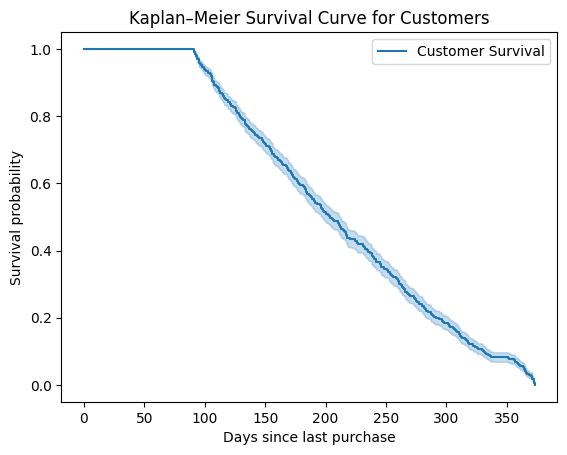

In [25]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Initialize Kaplan–Meier fitter
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(
    durations=survival_df["duration"],
    event_observed=survival_df["event"],
    label="Customer Survival"
)

# Plot survival curve
kmf.plot()
plt.xlabel("Days since last purchase")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier Survival Curve for Customers")
plt.show()


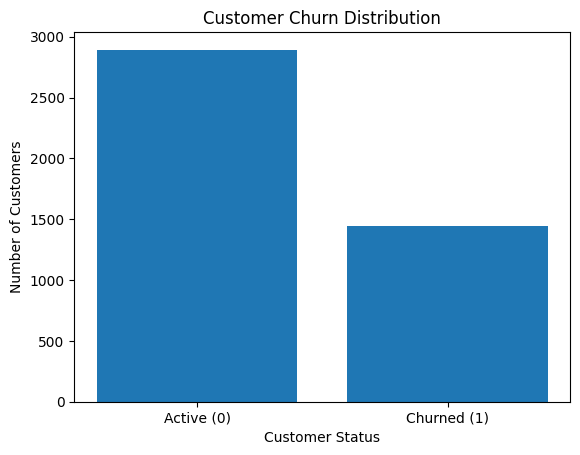

In [26]:
import matplotlib.pyplot as plt

# Count churn vs non-churn
churn_counts = customer_df["churn"].value_counts().sort_index()

# Plot bar chart
plt.bar(
    ["Active (0)", "Churned (1)"],
    churn_counts.values
)

plt.title("Customer Churn Distribution")
plt.ylabel("Number of Customers")
plt.xlabel("Customer Status")
plt.show()


In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest cleanly with no-leak features
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

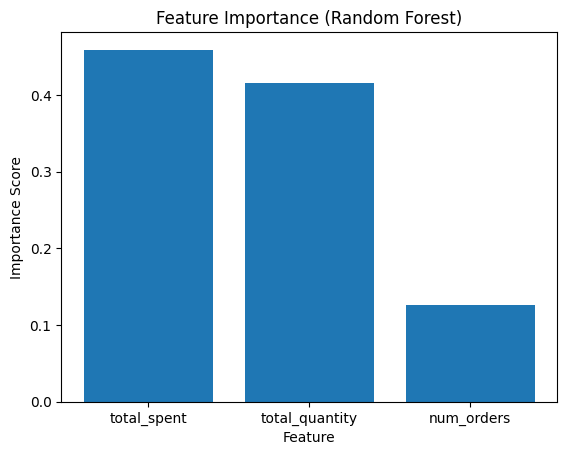

,feature,importance
2,total_spent,0.459041
1,total_quantity,0.415210
0,num_orders,0.125748


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Reconstruct feature names from the no-leak feature set
feature_names = ["num_orders", "total_quantity", "total_spent"]

# Extract importances (must match training features)
importances = rf_model.feature_importances_

# Safety check
assert len(feature_names) == len(importances)

# Create DataFrame
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot bar chart
plt.bar(importance_df["feature"], importance_df["importance"])
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.show()

importance_df
